# ADM - Homework #5

### Dependencies

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle as pkl
from time import time, mktime
import traceback
import sys
import os
from collections import OrderedDict
import csv
import datetime
import ast
import gc
from queue import PriorityQueue
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# set Benedetta Directory
os.chdir('/content/drive/MyDrive/Homework 5')

## 1. Data

Fetching the data from text files

In [4]:
class Graph():
    a2q = 'a2q'
    c2a = 'c2a'
    c2q = 'c2q'
    u = 'u'
    v = 'v'
    w = 'w'
    g = 'graph'
    timestamp = 'timestamp'
    _timestamp_csv = 'timestamp.csv'
    _a2q_filename = "sx-stackoverflow-a2q.txt"
    _c2a_filename = "sx-stackoverflow-c2a.txt"
    _c2q_filename = "sx-stackoverflow-c2q.txt"
    _my_graph = 'my_graph.pkl'
    def __init__(self):
        self.timestamp_file = None
        self.graph_info = dict()
    def _initialize(self, graph):
        self.adj_list = dict()
        if graph == Graph.a2q:
            self.filename = self._a2q_filename
            self.pkl = "a2q.pkl"
        elif graph == Graph.c2a:
            self.filename = self._c2a_filename
            self.pkl = "c2a.pkl"
        elif graph == Graph.c2q:
            self.filename = self._c2q_filename
            self.pkl = "c2q.pkl"
    def _get_graph_from_text(self):
        with open(self.filename, 'r') as file:
            graph_list = file.readlines()
            for i in tqdm(graph_list):
                l = list(map(int,i.split()))
                u, v, t = l[0], l[1], l[2]
                if v not in self.adj_list:
                    self.adj_list[v] = []
                if u in self.adj_list:
                    self.adj_list[u].append([v,t])
                else:
                    self.adj_list[u] = []
                    self.adj_list[u].append([v,t])
        self._dump_graph()
    def _dump_graph(self):
        with open(self.pkl, 'wb') as pkl_file:
            pkl.dump(self.adj_list, pkl_file)
    def get_graph(self, graph):
        t1 = time()
        self.graph = graph
        print("Starting to fetch {} graph adjacency list...".format(graph))
        self._initialize(graph)
        if not self.adj_list:
            try:
                with open(self.pkl, 'rb') as pkl_file:
                    self.adj_list = pkl.load(pkl_file)        
            except:
                self._get_graph_from_text()
        print("Fetched {} graph in {:.2f} seconds".format(self.graph, time() - t1))
        return self.adj_list
    def releave_graph(self):
        del self.adj_list
        gc.collect()
    def make_graph(self, timespan):
        r = self.timestamp_file.readlines()
        self.my_graph = dict()
        t1, t2 = timespan
        flag = True
        print("Creating graph!")
        for i in tqdm(r):
            if flag:
                flag = False
                continue
            l = i.split(",")
            t, u, v, w = int(l[0]), int(l[1]), int(l[2]), float(l[3])
            if t1 <= t <= t2:
                if v not in self.my_graph.keys():
                    self.my_graph[v] = []
                if u in self.my_graph.keys():
                    self.my_graph[u].append([v,w])
                else:
                    self.my_graph[u] = []
                    self.my_graph[u].append([v,w])
        del r
        del self.timestamp_file
        gc.collect()
        
        with open(self._my_graph, 'wb') as file:
            pkl.dump(self.my_graph, file)
    def get_timestamp(self,timespan):
        self.timestamp_file = open(self._timestamp_csv, 'r')
        self.make_graph(timespan)
    def create_graph(self, graphs, timespan):
        d1, d2 = timespan[0], timespan[1]
        t1 = int(mktime(datetime.datetime.strptime(d1, "%d/%m/%Y").timetuple()))
        t2 = int(mktime(datetime.datetime.strptime(d2, "%d/%m/%Y").timetuple()))
        timespan = (t1, t2)
        if os.path.isfile(self._timestamp_csv):
            t1 = time()
            print("Fetching {}...".format(self._timestamp_csv))
            self.get_timestamp(timespan)
            print("Fetched in {:.2f} seconds.".format(time()-t1))
        else:
            timestamp_dict = dict()
            with open(self._timestamp_csv, 'w', newline='') as timestamp_file:
                writer = csv.writer(timestamp_file)
                writer.writerow([self.timestamp, self.u, self.v, self.w, self.g])
                for graph in graphs:
                    if graph == self.a2q:
                        w = np.e**3
                        filename = self._a2q_filename
                    elif graph == self.c2q:
                        w = np.e**2
                        filename = self._c2q_filename
                    elif graph == self.c2a:
                        w = np.e
                        filename = self._c2a_filename
                    print("Converting graph {} to timestamp dictionary with w={} ...".format(graph, str(w)) )
                    with open(filename, 'r') as file:
                        graph_list = file.readlines()
                        for i in tqdm(graph_list):
                            l = list(map(int,i.split()))
                            u, v, t = l[0], l[1], l[2]
                            writer.writerow([t,u,v,w,graph])
                        del graph_list
                        gc.collect()
            print("Done!!!")
            gc.collect()
            self.get_timestamp(timespan)

In [5]:
g = Graph()
list_of_graphs = [Graph.a2q, Graph.c2q, Graph.c2a]

In [6]:
g.create_graph(list_of_graphs , ["01/12/2011","05/12/2011"])

Fetching timestamp.csv...
Creating graph!


100%|██████████| 63497051/63497051 [02:09<00:00, 489249.68it/s]


Fetched in 182.93 seconds.


What to do to create a graph that contains certain time interval:
1. Instantiate g = Graph
2. Use g.create_graph(list_of_graphs, "YOUR TIME INTERVAL") to create a graph with edges within a time interval
3. Use g.my_graph to get the graph's adjacency list. Remember that the adjacency list here is actualy a dictionary with keys as nodes and values as neighbors with their connection weight. {u: [[v1,w1], [v2,w2], ...]}

## 2. Implementation of the backend

### Functionality 1 - Get the overall features of the graph

In [7]:
def func1(graph: Graph, graph_name: str, threshold = 0.2):
    """
    test_function does blah blah blah.
    
    :param graph: instantialized Graph object
    :param graph_name: name of the graph among Graph.a2q, Graph.c2q, and Graph c2a
    :param threshold: threshold of the sparseness of the graph (must be lower than 0.5)
    :return: a list -> [Whether the graph is directed or not, Number of users, Number of answers/comments,
                Average number of links per user, Density degree of the graph,
                Whether the graph is sparse, Whether the graph is dense]
    """ 
    graph.get_graph(graph_name)
    is_directed = False;
    keys = graph.adj_list.keys()
    vertex_num = len(keys)
    degree = 0
    links_per_users_num = 0
    density_degree = 0
    is_sparse = 0
    is_dense = 0
    density = []
    for key in tqdm(keys):
        val = graph.adj_list[key]
        density.append(len(graph.adj_list[key]))

        if len(val)>=1:
            val = np.array(val)[:,0]
            degree += len(val)
            if not is_directed:
                for v in val:
                    if v in graph.adj_list.keys():
                        val_v = graph.adj_list[v]
                        if len(val_v)>=1:
                            val_v = set(np.array(graph.adj_list[v])[:,0].flatten())
                            if key in val_v:
                                continue;
                            else:
                                is_directed = True
                                break
    links_per_users_num = degree / vertex_num
    clique_num = (vertex_num * (vertex_num - 1)) / 2
    density_degree = (degree // 2) / clique_num
    if density_degree >= (1-threshold) * clique_num:
        is_dense = 1
    elif density_degree <= threshold * clique_num:
        is_sparse = 1

    graph.releave_graph()

    return [is_directed, vertex_num, degree, links_per_users_num, density_degree, is_sparse, is_dense, density]

In [ ]:
print(func1(g, Graph.c2q))

Starting to fetch c2q graph adjacency list...


  0%|                                                                         | 1880/1655353 [00:00<02:58, 9281.16it/s]

Fetched c2q graph in 21.11 seconds


100%|█████████████████████████████████████████████████████████████████████| 1655353/1655353 [00:17<00:00, 92795.60it/s]


[True, 1655353, 20268151, 12.244005357165511, 7.396617005364873e-06, 1, 0]


###  Functionality 2 - Find the best users! 

In [27]:
def dijkstra(graph: dict, u_init: int):
    nodes = graph.keys()
    path_w = dict(zip(nodes, [float('inf')] * len(nodes)))
    path_visited = dict(zip(nodes, [-1] * len(nodes)))
    path_w[u_init] = 0
    
    unvisited = [u for u in nodes]
    while len(unvisited) > 0:
#         if len(unvisited) % 1000 == 0:
#             print(len(unvisited))
        choices = {v: path_w[v] for v in unvisited}
        u = min(choices, key=choices.get)
        unvisited.remove(u)
        for v, w in graph[u]:
            if path_w[v] > path_w[u] + 1/w:
                path_visited[v] = u
            path_w[v] = min(path_w[v], path_w[u] + 1/w)
    return path_w, path_visited

In [28]:
def bfs(graph: dict, u_init: int, v_dest: int):
    visited = dict(zip(graph.keys(), [False] * len(graph.keys())))
    dist = dict(zip(graph.keys(), [0] * len(graph.keys())))
    parent = dict(zip(graph.keys(), [-1] * len(graph.keys())))
    visited[u_init] = True
    queue = []
    queue.extend(np.array(graph[u_init])[:,0])
    while queue:
        v = queue.pop()
        if not visited[v]:
            visited[v] = True
            v_neighbors = np.array(graph[v])
            if len(v_neighbors) > 0:
                queue.extend(v_neighbors[:, 0])
                for vn, w_vn in v_neighbors:
                    dist[vn] = dist[v] + 1
                    parent[vn] = v
                    if vn == v_dest:
                        return dist[vn], parent
    

In [29]:
class Metric():
    betweenness = "Betweenness"
    pagerank = "PageRank"
    closeness_cent = "ClosenessCentrality"
    degree_cent = "DegreeCentrality"
    def compute_betweeness(self, graph: dict):
        self.sp = dict()
        for key in graph.keys():
            val = graph[key]
            dijkstra(graph, key)
            break
    def compute_page_rank(self, graph: dict):
        self.pr = dict()
        keys = graph.keys()
        n = len(keys)
        r_default = 1/n
        for key in tqdm(keys):
            val = graph[key]
            if len(val) >= 1:
                val = np.array(val)[:,0]
                out_degree = len(val)
                if key not in self.pr.keys():
                    self.pr[key] = [r_default, out_degree, []]
                for v in val:
                    if v in self.pr.keys():
                        self.pr[v][2].append(key)
                    else:
                        out_degree_v = len(graph[v])
                        self.pr[v] = [r_default, out_degree_v, [key]]     
        epsilon = 0.000000001
        beta = 0.2
        while True:
            d = dict()
            for vertex in self.pr.keys():
                u = self.pr[vertex]
                r_prev = u[0]
                in_degrees = u[2]
                r = 0
                for v in in_degrees:
                    r += beta * (self.pr[v][0]/self.pr[v][1])
                r += (1 - beta)/n
                self.pr[vertex][0] = r
                cond = abs(r - r_prev)
                d[vertex] = cond
                if cond <= epsilon:
                    break
            a = np.array(list(d.values()))
            if len(a[a > epsilon]) == 0:
                break;


In [30]:
def func2(graph: dict, metric: Metric, node: int, metric_type):
    """
    test_function does blah blah blah.
    
    :param graph: instantialized Graph object
    :param metric: instantiated metric object
    :param node: The node that the func2 is going to be applied to
    :param metric_type: the type of the metric wanted [Metric.pagerank, Metric.betweenness, Metric.closeness_cent, Metric.degree_cent]
    :return: a list -> [Whether the graph is directed or not, Number of users, Number of answers/comments,
                Average number of links per user, Density degree of the graph,
                Whether the graph is sparse, Whether the graph is dense]
    """ 
    if metric_type == Metric.pagerank:
        metric.compute_page_rank(graph)
        return metric.pr[node][0]
    elif metric_type == Metric.betweenness:
        metric.compute_betweeness(graph)

In [31]:
metric = Metric()

In [32]:
func2(g.my_graph, metric, 1040563, Metric.pagerank)

100%|██████████| 27080/27080 [00:00<00:00, 83624.46it/s]


3.692762186115214e-05

### Functionality 3 - Shortest Ordered Route 

In [33]:
def find_walk(walk: dict, start: int, end: int):
    u = end
    l = []
    while u != start:
        if u == -1:
            break
        parent = walk[u]
        l.append(parent)
        u = parent
    l.reverse()
    return l

def find_shortest_path(graph, start, end):
    l = []
    t1 = time()
    d, walk = dijkstra(graph, start)
    d = d[end]
    walk_dist = d
    x = find_walk(walk, start, end)
    if x != -1:
        l.append(x)
    else:
        return "Not Possible", []
    print("Node {} to {}, shortest distance: {}, time: {:.2f} secs".format(start, end, walk_dist, time() - t1))
    return walk_dist, l
def func3(graph: dict, pj, pn, p):
    l = []
    walk_dist = 0
    wd, li = find_shortest_path(graph, pj, p[0])
    walk_dist += wd
    l.extend(*li)
    for i in range(len(p) - 1):
        wd, li = find_shortest_path(graph, p[i], p[i+1])
        walk_dist += wd
        l.extend(*li)
    wd, li = find_shortest_path(graph, p[len(p)-1], pn)
    walk_dist += wd
    l.extend(*li)
    l.append(pn)
    return walk_dist, l

In [ ]:
t1 = time()
walk_dist, walk = func3(g.my_graph, 1040563, 908515, [738746, 319749, 522444])
print("Found the walk distance in {:.2f} seconds".format(time() - t1))

In [ ]:
walk

In [ ]:
walk_dist

5.553339247418126

In [ ]:
bfs(g.my_graph, 1040563, 522444)[1]
# find_walk(, 1040563, 522444)

In [ ]:
bfs(g.my_graph, 1040563, 522444)

374

### Functionality 4 - Disconnecting graphs 

In [35]:
def combine_graphs(graph1, graph2):
    d = {}
    for k in graph1.keys():
        if len(graph1[k]) > 0:
            if k in d.keys():
                d[k].extend(graph1[k])
            else:
                d[k] = graph1[k]
    for k in graph2.keys():
        if len(graph2[k]) > 0:
            if k in d.keys():
                d[k].extend(graph2[k])
            else:
                d[k] = graph2[k]
    return d

In [36]:
def find_unique_nodes(graph1, graph2):
    u1s = []
    u2s = []
    for i in graph1.keys():
        if i not in graph2.keys() and len(graph1[i]) > 1:
            u1s.append(i)
    for i in graph2.keys():
        if i not in graph1.keys() and len(graph2[i]) > 1:
            u2s.append(i)
    return u1s, u2s

In [37]:
def func4(graph, u1, u2):
    if u2 in graph1 or u1 in graph2:
        raise Exception("u1 or u2 are not unique in their own graphs")

In [ ]:
g2 = Graph()
g2.create_graph(list_of_graphs , ["04/12/2011","07/12/2011"])

Fetching timestamp.csv...


  0%|                                                                     | 74624/63497051 [00:00<02:50, 372238.68it/s]

Creating graph!


100%|██████████████████████████████████████████████████████████████████| 63497051/63497051 [02:40<00:00, 395235.13it/s]


Fetched in 188.16 seconds.


In [ ]:
u1s, u2s = find_unique_nodes(g.my_graph, g2.my_graph)

u1s is a list of nodes that are unique to g.my_graph and u2s is a list of nodes that are unique to g2.my_graph

In [ ]:
combined_graph = combine_graphs(g.my_graph, g2.my_graph)

## 3. Implementation of the frontend

### Visualization 1 - Visualize the overall features of the graph

In [8]:
def choose_the_graph():

  # let the user choose  which type of graoh he is interested in
  graph_type = input('Choose a graph: \nA: Graph with answers to questions \nB: Graph with comments to questions \nC: Graph with comments to answers\n')
  if graph_type == 'A':
    choose_graph, gr = Graph.a2q, 'answers to questions'
  elif graph_type == 'B':
    choose_graph, gr = Graph.c2q, 'comments to questions'
  elif graph_type == 'C':
    choose_graph, gr = Graph.c2a, 'comments to answers'
  return(choose_graph, gr)

In [19]:
def visualization1(g):

  '''This function returns a table which contains some important features that characterize a graph.
   The graph which we are dealing with is chosen by the user'''

  choose_graph, gr = choose_the_graph()

  # call the function of the first functionality to get some summaries of the chosen graph
  is_directed, vertex_num, degree, links_per_users_num, density_degree, is_sparse, is_dense, distr_degree = func1(g, choose_graph)
  # modify some output for the visualization 
  if is_directed:
    directed = "It's directed!"
  else:
    directed = "It's undirected!"
  if is_sparse == 1:
    sparse = "It's sparse!"
  else:
    sparse = "It's dense!"
  links_per_users_num = round(links_per_users_num,3)
  density_degree = round(density_degree,5)

  # print the table 
  print('\n\nGraph with '+gr)
  d = {'Summary': [directed,vertex_num,degree,links_per_users_num,density_degree,sparse]}
  df = pd.DataFrame(data=d, index = ["Directed or Undirected?","Number users",
                                     "Number of comments/answers","Average degree",
                                     "Density degree","Sparse or Dense?"])
  
  print(df)

  # plot the distribution of degrees in the network
  plt.figure(figsize = (13,8))
  sns.set(style="darkgrid")
  sns.distplot(distr_degree)
  plt.title('Distribution of degree in the graph '+gr, fontsize = 17)
  plt.show()

  

Choose a graph: 
A: Graph with answers to questions 
B: Graph with comments to questions 
C: Graph with comments to answers
A
Starting to fetch a2q graph adjacency list...
Fetched a2q graph in 21.74 seconds


100%|██████████| 2464606/2464606 [00:23<00:00, 104879.49it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)




Graph with answers to questions
                                   Summary
Directed or Undirected?     It's directed!
Number users                       2464606
Number of comments/answers        17823525
Average degree                       7.232
Density degree                           0
Sparse or Dense?              It's sparse!


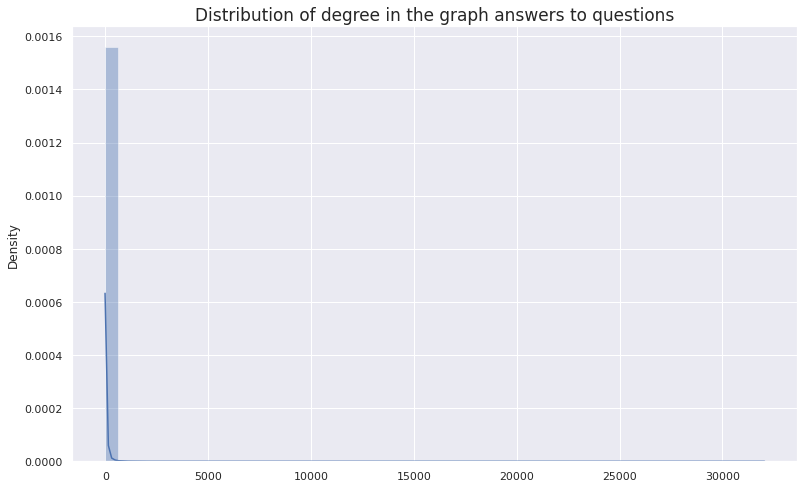

In [20]:
visualization1(g)

### Visualization 2 - Visualize the best user! 

In [ ]:
# not necessary but useful to choose the node
import random
random_amounts = 500

nodes = []
for i in range(random_amounts) :
  random_node = random.choice(list(g.my_graph.keys()))
  nodes.append((len(g.my_graph[random_node]), random_node))

nodes.sort(reverse = True)
print(nodes)

In [41]:
def create_my_graph(g):

  # create a graph with networkx library
  myG = nx.DiGraph()

  # add edges to the graph 
  for u in list(g.keys()):
    for v in g[u]:
      if u != v:
        myG.add_edge(u, v[0], weight=v[1])
        
  return myG

In [42]:
def create_my_subgraph(g, input_node = 119477):

  # create a graph 
  myG = create_my_graph(g)

  # select the neighbors of an input node
  node_neighbors = [input_node]
  neighbors = g[input_node]
  for node in neighbors:
    node_neighbors.append(node[0])
  
  # create the subgraph with networkx
  subG = myG.subgraph(node_neighbors)  

  return(subG)


In [43]:
def plot_subgraph(g, chosen_node, m_name, value_metric):


  # create the sub graph
  subG = create_my_subgraph(g, input_node = chosen_node)
  
  # plot the graph
  plt.figure(figsize=(20,10))
  
  # classify the edges based on the weight that they have: 
  # light: 'Comment to answer'
  # medium: 'Comment to question'
  # small: 'Answer to question'

  elarge = [(u, v) for (u, v, d) in subG.edges(data=True) if u != v and d["weight"] == np.e**3]
  emedium = [(u, v) for (u, v, d) in subG.edges(data=True) if  u != v and d["weight"] == np.e**2]
  esmall = [(u, v) for (u, v, d) in subG.edges(data=True) if u != v and d["weight"] == np.e]

  # positions for all nodes - seed for reproducibility

  pos = nx.spring_layout(subG, k=0.40, iterations=20, seed = 12)  

  # add nodes to the graph
  nx.draw_networkx_nodes(subG, pos, node_size=800, node_color='olive', 
                         alpha = .5, label = 'Neighbors of input node')

  # draw the node of interest (input)
  nx.draw_networkx_nodes(subG, pos, node_size=800, nodelist = [chosen_node], 
                         node_color='crimson', label = 'Input node: {}'.format(chosen_node))

  # add edges to the graph
  nx.draw_networkx_edges(subG, pos, edgelist=elarge, width=3, alpha = 0.8, edge_color="steelblue", 
                         arrowsize=15, connectionstyle='arc3,rad=0.05')
  nx.draw_networkx_edges(subG, pos, edgelist=emedium, width=2.3, alpha=0.5, edge_color="skyblue",
                         arrowsize=15, connectionstyle='arc3,rad=-0.3')
  nx.draw_networkx_edges(subG, pos, edgelist=esmall, width=1.5, alpha=0.3, edge_color="slategray",
                         arrowsize=15, connectionstyle='arc3,rad=0.5')


  ax = plt.gca()
  ax.margins(0.03)
  plt.axis("off")
  plt.title('Network of the neighborhood of the input node {}'.format(chosen_node), fontsize = 22)
  box = dict(boxstyle='round', facecolor='snow', alpha=0.7, edgecolor="grey")
  plt.suptitle('Metric: {}\nValue: {}'.format(m_name, value_metric),x= .51,y = 0.55, fontsize = 18, bbox=box, horizontalalignment = 'left')
  plt.tight_layout()
  plt.legend(fontsize = 20, markerscale = .7)

  plt.show()

In [44]:
def choose_the_metric():

  # let the user choose  which type of metric he is interested in
  metric_type = input('Choose a metric: \nA: Pagerank \nB: Betweeness \nC: ClosenessCentrality\nD: DegreeCentrality \n')
  if metric_type == 'A':
    choose_metric, metric = Metric.pagerank, 'Pagerank'
  elif metric_type == 'B':
    choose_metric, metric = Metric.betweness, 'Betweeness'
  elif metric_type == 'C':
    choose_metric, metric = Metric.centrality, 'ClosenessCentrality'
  elif metric_type == 'D':
    choose_metric, metric = Metric.degreeCentrality, 'DegreeCentrality'
  return(choose_metric, metric)

In [45]:
def visualization2(g):

  # Let the user choose the node
  chosen_node = int(input('Choose a node! \n'))
  choose_metric, m = choose_the_metric()

  metric = Metric()
  value_metric = func2(g, metric, chosen_node, choose_metric)

  plot_subgraph(g, chosen_node, m, value_metric)




Choose a node! 
984393
Choose a metric: 
A: Pagerank 
B: Betweeness 
C: ClosenessCentrality
D: DegreeCentrality 
A


100%|██████████| 27080/27080 [00:00<00:00, 83929.16it/s]


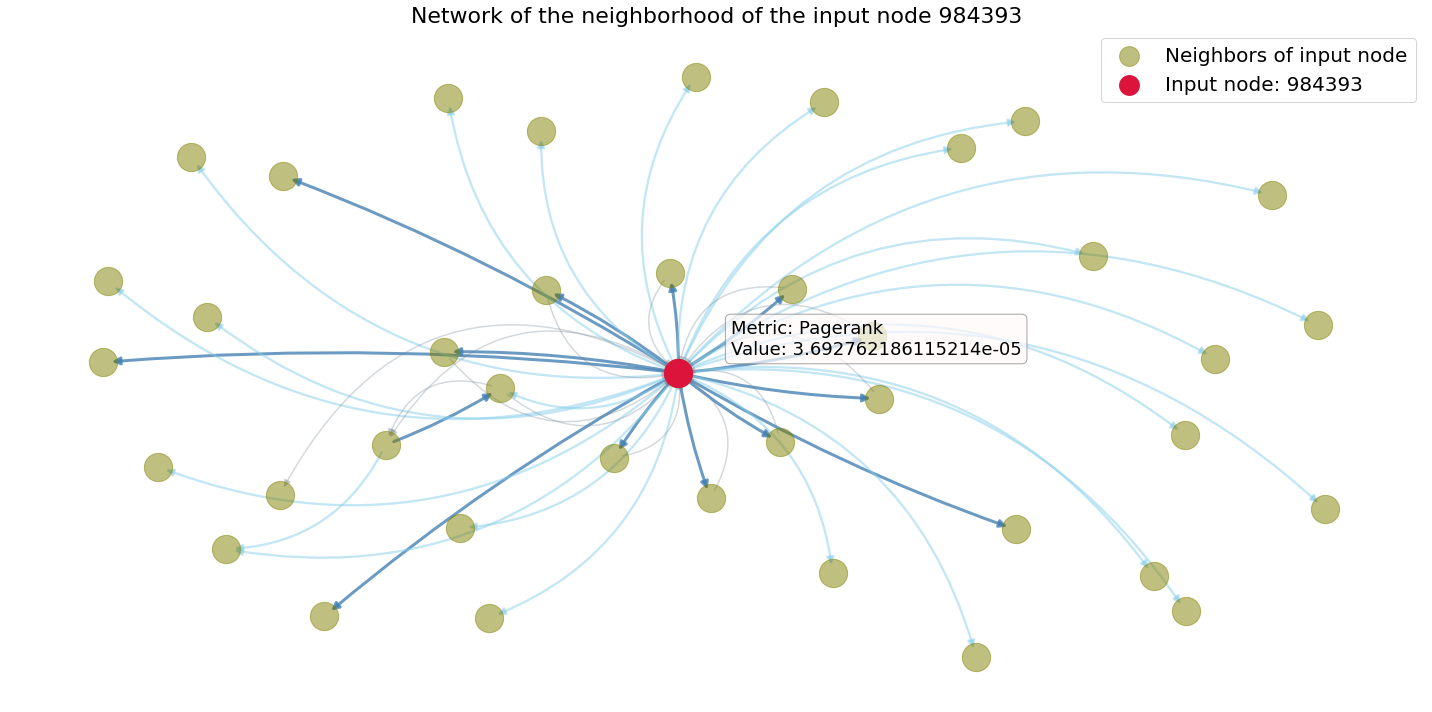

In [ ]:
visualization2(g.my_graph)

### Visualization 3 - Visualize the Shortest Ordered Route 

In [38]:
def choose_the_nodes():
  p1 = int(input('Choose the starting node:  '))
  pn = int(input('Choose the end node:  '))
  p = list(map(int, input("Choose the nodes to pass through:   ").strip().split()))
  return p1,pn,p

In [39]:
def create_my_subgraph_2(g, path):

  # create a graph 
  myG = create_my_graph(g)

  # select the neighbors' nodes in the path

  subgraph_node = []
  for u in path:
    subgraph_node.append(u)
    neighbors = g[u]
    for node in neighbors:
      subgraph_node.append(node[0])

  subgraph_node = set(subgraph_node)

  # create the subgraph with networkx
  subG = myG.subgraph(subgraph_node) 
  return subG 


In [50]:
def plot_path(g, path, p1, pn, p):

  # create the sub graph
  subG = create_my_subgraph_2(g, path)
  
  # classify the edges based on the weight that they have: 
  # light: 'Comment to answer'
  # medium: 'Comment to question'
  # small: 'Answer to question'

  elarge = [(u, v) for (u, v, d) in subG.edges(data=True) if u != v and d["weight"] == np.e**3]
  emedium = [(u, v) for (u, v, d) in subG.edges(data=True) if  u != v and d["weight"] == np.e**2]
  esmall = [(u, v) for (u, v, d) in subG.edges(data=True) if u != v and d["weight"] == np.e]

  e_path = []
  for i in range(len(path)-1):
    print
    e_path.append((path[i],path[i+1]))

  epath_large = []
  epath_medium = []
  epath_small = []
  for (u, v, d) in subG.edges(data=True):
    for e in e_path:
      if e == (u,v):
        if d["weight"] == np.e**3:
          epath_large.append((u,v))
        elif d["weight"] == np.e**2:
          epath_medium.append((u,v))
        elif d["weight"] == np.e:
          epath_small.append((u,v))

  plt.figure(figsize=(20,10))

  # positions for all nodes - seed for reproducibility

  pos = nx.spring_layout(subG, k=0.40, iterations=20, seed = 555)  

  # add nodes to the graph
  nx.draw_networkx_nodes(subG, pos, node_size=400, node_color='snow',alpha = .4, edgecolors = 'black')

  # draw nodes of path
  nx.draw_networkx_nodes(subG, pos, node_size=400, nodelist = path, alpha = 0.6,
                          node_color='cornflowerblue',label = 'Nodes of the shortest path from $p_1$ to $p_n$')

  nx.draw_networkx_nodes(subG, pos, node_size=600, nodelist = p, alpha = 0.8,
                          node_color='green', label = 'Nodes to must pass through  $p=$ {}'.format(p))

  nx.draw_networkx_nodes(subG, pos, node_size=800, nodelist = [p1], 
                          node_color='crimson', label = 'Start node   $p_1 = $ {}'.format(p1))

  nx.draw_networkx_nodes(subG, pos, node_size=800, nodelist = [pn], 
                          node_color='navy', label = 'End node    $p_n = ${}'.format(pn))


  # add edges to the graph
  nx.draw_networkx_edges(subG, pos, edgelist=elarge, width=5, alpha = 0.3, edge_color="grey", 
                          arrowsize=15, connectionstyle='arc3,rad=0.05')
  nx.draw_networkx_edges(subG, pos, edgelist=emedium, width=3.5, alpha=0.25, edge_color="darkgrey",
                          arrowsize=15, connectionstyle='arc3,rad=-0.3')
  nx.draw_networkx_edges(subG, pos, edgelist=esmall, width=2, alpha=0.2, edge_color="lightgray",
                          arrowsize=15, connectionstyle='arc3,rad=0.5')

  # add edges of the path
  nx.draw_networkx_edges(subG, pos, edgelist=epath_large, width=5, edge_color="gold", 
                          arrowsize=15, connectionstyle='arc3,rad=0.05')
  nx.draw_networkx_edges(subG, pos, edgelist=epath_medium, width=3.5, edge_color="gold",
                          arrowsize=15, connectionstyle='arc3,rad=-0.3')
  nx.draw_networkx_edges(subG, pos, edgelist=epath_small, width=2, edge_color="gold",
                          arrowsize=15, connectionstyle='arc3,rad=0.5')

  ax = plt.gca()
  ax.margins(0.03)
  plt.axis("off")
  plt.title('Shortest path from $p_1$ to $p_n$ that pass through $p$ (Overview plot)', fontsize = 22)
  plt.tight_layout()
  plt.legend(fontsize = 14, markerscale = .7)
  plt.show()
    


In [47]:
def detailed_plot_path(g, path, p1, pn, p, walk_dist):

  # create the graph
  myG = create_my_graph(g)

  # create the subgraph
  subG = myG.subgraph(path) 

  # create the network 

  e_path = []
  for i in range(len(path)-1):
    print
    e_path.append((path[i],path[i+1]))

  # define the edges
  epath_large = []
  epath_medium = []
  epath_small = []
  for (u, v, d) in subG.edges(data=True):
    for e in e_path:
      if e == (u,v):
        if d["weight"] == np.e**3:
          epath_large.append((u,v))
        elif d["weight"] == np.e**2:
          epath_medium.append((u,v))
        elif d["weight"] == np.e:
          epath_small.append((u,v))

  plt.figure(figsize=(20,7))

  # positions for all nodes - seed for reproducibility

  pos = nx.spring_layout(subG, k=0.40, iterations=20, seed = 14)  


  # draw nodes of path
  nx.draw_networkx_nodes(subG, pos, node_size=400, nodelist = path, alpha = 0.6,
                          node_color='cornflowerblue',label = 'Nodes of the shortest path from $p_1$ to $p_n$')

  nx.draw_networkx_nodes(subG, pos, node_size=600, nodelist = p, alpha = 0.8,
                          node_color='green', label = 'Nodes to must pass through  $p=$ {}'.format(p))

  nx.draw_networkx_nodes(subG, pos, node_size=800, nodelist = [p1], 
                          node_color='crimson', label = 'Start node  $p_1 = $ {}'.format(p1))

  nx.draw_networkx_nodes(subG, pos, node_size=800, nodelist = [pn], 
                          node_color='navy', label = 'End node    $p_n = ${}'.format(pn))


  # draw edges of the path
  nx.draw_networkx_edges(subG, pos, edgelist=epath_large, width=5, edge_color="gold", 
                          arrowsize=15, connectionstyle='arc3,rad=0.05')
  nx.draw_networkx_edges(subG, pos, edgelist=epath_medium, width=3.5, edge_color="gold",
                          arrowsize=15, connectionstyle='arc3,rad=-0.3')
  nx.draw_networkx_edges(subG, pos, edgelist=epath_small, width=2, edge_color="gold",
                          arrowsize=15, connectionstyle='arc3,rad=0.5')

  ax = plt.gca()
  ax.margins(0.03)
  plt.axis("off")
  plt.title('A better representation of the path!', fontsize = 22)
  box = dict(boxstyle='round', facecolor='gold', alpha=0.4, edgecolor="gold")
  plt.suptitle('The walk distance between $p_1$ and $p_n$ is {}'.format(walk_dist),x= .5,y = 0.9, fontsize = 15, bbox=box)
  plt.tight_layout()
  plt.show()

In [48]:
def visualization3(g):

  # Let the user choose the start node, the end node and the nodes to must pass through 
  p1,pn,p = choose_the_nodes()

  # functionality 3 to get the path
  walk_dist, path = func3(g, p1, pn, p)

  # create the network
  plot_path(g, path, p1, pn, p)

  # create a detailed network
  detailed_plot_path(g, path, p1, pn, p, walk_dist)


TRY THIS INPUT 

p1: 663368

pn: 908515

p: 738746  319749  522444 

Choose the starting node:  663368
Choose the end node:  908515
Choose the nodes to pass through:   738746 319749 522444
Node 663368 to 738746, shortest distance: 1.203212460250055, time: 127.78 secs
Node 738746 to 319749, shortest distance: 1.5236700950911444, time: 139.42 secs
Node 319749 to 522444, shortest distance: 1.3385477434866675, time: 126.95 secs
Node 522444 to 908515, shortest distance: 1.0204553706830892, time: 128.35 secs


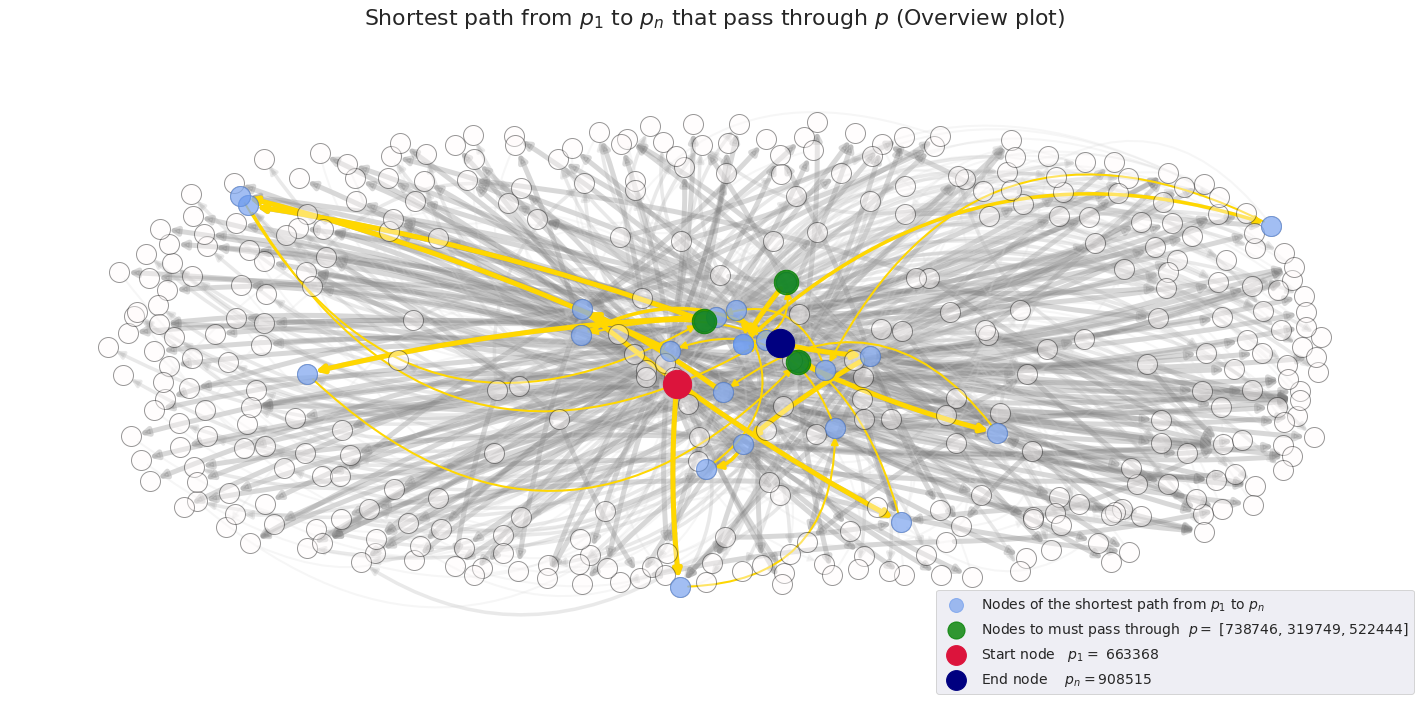

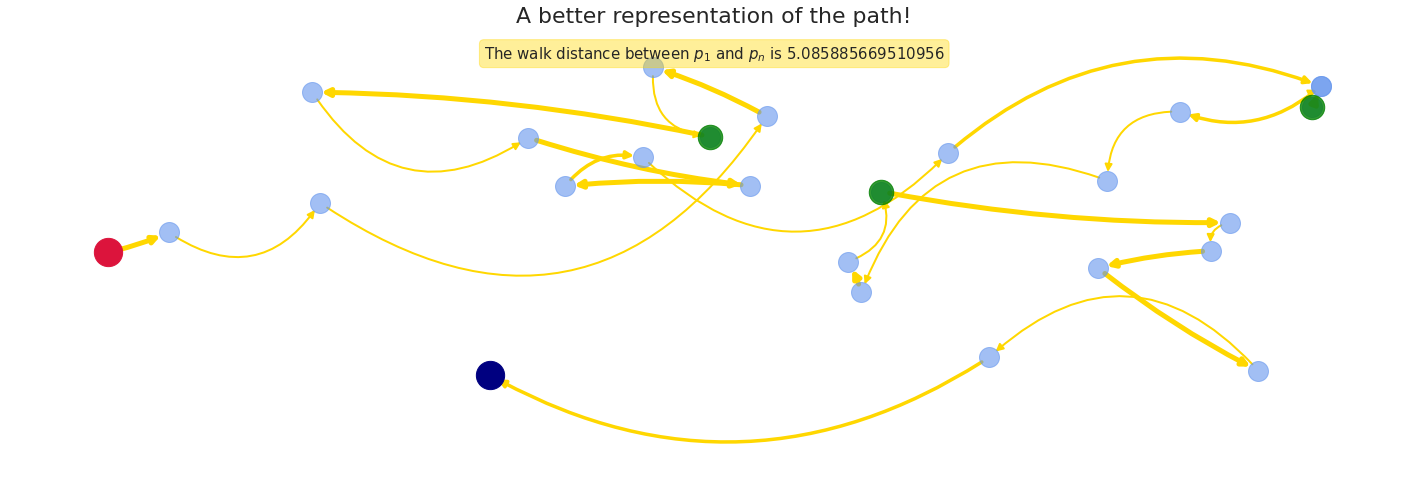

In [51]:
visualization3(g.my_graph)

### Visualization 4 - Visualize disconnecting graphs 

## 4. Algorithmic question

In the algorithm we have implemented there are two "for" loops in "pairs", and we denote the length of "pairs" with _k_. Then there is a "for" loop in "kids", and we denote the length of "kids" with _n_. Therefore, since the "for" loops are not nested, we have that the running time of the algorithm is _O_(_n_ + 2 _k_). So we can conclude that the algorithm is linear in _n_ and in _k_.

In [ ]:
def list_of_dorms(kids, pairs):
    # INPUT:
    # kids -> list of kids
    # pairs -> list of pair sof kids with fights
    
    # These are the lists of the two dorms
    dorm1 = []
    dorm2 = []
    
    # I create a list with which I keep track of the kids already visited
    visited = []
    
    # I start separating the pairs
    for pair in pairs: 
        
        # If the kid "pair[0]" has not yet been visited
        if (pair[0] not in visited):
            # I check if the other kid of the pair (that is "pair[1]") is already in "dorm1"
            # If "pair[1]" is not in "dorm1", then I visit "pair[0]" and I add it to "dorm1"
            if (pair[1] not in dorm1):
                visited.append(pair[0])
                dorm1.append(pair[0])
            # Otherwise, I visit "pair[0]" and I add it to "dorm2"
            else:
                visited.append(pair[0])
                dorm2.append(pair[0])
                
        # Then I do the same thing for the second kid of the pair, that is "pair[1]"
        # If the kid "pair[1]" has not yet been visited   
        if(pair[1] not in visited):
            # I check if the other kid of the pair (that is "pair[0]") is already in "dorm2"
            # If "pair[0]" is not in "dorm2", then I visit "pair[1]" and I add it to "dorm2"
            if (pair[0] not in dorm2):
                visited.append(pair[1])
                dorm2.append(pair[1])
            # Otherwise, I visit "pair[1]" and I add it to "dorm1"
            else:
                visited.append(pair[1])
                dorm1.append(pair[1])
    
    # Now I check if kids who are in the same pair are in the same dorm
    # If this happens, I block the algorithm and exit
    for pair in pairs:
        if ((pair[0] in dorm1) and (pair[1] in dorm1)) or (pair[0] in dorm2) and (pair[1] in dorm2):
            print("Nothing to do.")
            return 
    
    # Now I add the kids who remained in the dorms
    # Since there are no space limits in the dorms, 
    # I decide to assign all the remaining children to the first dormitory
    for kid in kids:
        if (kid not in dorm1) and (kid not in dorm2):
            dorm1.append(kid)
    
    # At the end I print the lists of the two dorms
    print("Solution found! Here the list of dorms:")
    print("First dormitory:", dorm1)
    print("Second dormitory:",dorm2)

##### Example 1

In [ ]:
kids = [1,2,3,4,5,6]
pairs = [(5,4), (6,5), (2,6)]
list_of_dorms(kids, pairs)

Solution found! Here the list of dorms:
First dormitory: [5, 2, 1, 3]
Second dormitory: [4, 6]


##### Example 2

In [ ]:
kids = [1,2,3,4,5,6]
pairs = [(1,2), (3,2), (3,1)]
list_of_dorms(kids, pairs)

Nothing to do.


##### Example 3

In [ ]:
kids = [1,2,3,4,5,6]
pairs = [(1,3), (4,3)]
list_of_dorms(kids, pairs)

Solution found! Here the list of dorms:
First dormitory: [1, 4, 2, 5, 6]
Second dormitory: [3]


##### Example 4

In [ ]:
n = [4,2,1,3,5,6]
k = [(1,2), (3,2), (3,1)]
list_of_dorms(n,k)

Nothing to do.


##### Example 5

In [ ]:
kids = ['Anthony', 'Luke', 'Emily', 'John', 'Mary', 'Sophie']
pairs = [('Anthony', 'Mary'), ('Emily', 'John')]
list_of_dorms(kids, pairs)

Solution found! Here the list of dorms:
First dormitory: ['Anthony', 'Emily', 'Luke', 'Sophie']
Second dormitory: ['Mary', 'John']


##### Example 6

In [ ]:
kids = ['Anthony', 'Luke', 'Emily', 'John', 'Mary', 'Sophie']
pairs = [('Anthony', 'Emily'), ('John', 'Emily')]
list_of_dorms(kids, pairs)

Solution found! Here the list of dorms:
First dormitory: ['Anthony', 'John', 'Luke', 'Mary', 'Sophie']
Second dormitory: ['Emily']


##### Example 7

In [ ]:
kids = ['Anthony', 'Luke', 'Emily', 'John', 'Mary', 'Sophie']
pairs = [('Anthony', 'Mary'), ('Anthony', 'John'), ('Mary', 'John')]
list_of_dorms(kids, pairs)

Nothing to do.
